In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import MinMaxScaler


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# [Tutorial](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/)

## Load the Data 

In [ ]:
#Run Local
#df = pd.read_csv("csv/book_info_complete.csv")
#Run on COLAB
df = pd.read_csv("/content/drive/My Drive/final_project/book_info_complete.csv")

In [4]:
df = df.dropna(axis=1)
df["Publication date"] = df["Publication date"].str[-4:].astype(int)
df = df.drop("Last updated", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             5816 non-null   object
 1   description       5816 non-null   object
 2   plot              5816 non-null   object
 3   csm_review        5816 non-null   object
 4   need_to_know      5816 non-null   object
 5   csm_rating        5816 non-null   int64 
 6   Genre             5816 non-null   object
 7   Book type         5816 non-null   object
 8   Publication date  5816 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 409.1+ KB


### Lower and remove stop words

In [ ]:
columns = ['title', "description", "plot", "csm_review", "need_to_know"]

df = df.applymap(lambda x: x.lower() if type(x) == str else x)

df[columns] = df[columns].applymap(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [6]:
df.head(1)

,title,description,plot,csm_review,need_to_know,csm_rating,Genre,Book type,Publication date
0,third twin,gripping thriller skimps character development.,"twins ava alexa ""lexi"" rios live affluent sout...","third twin interesting, compelling premise: bo...",parents need know third twin murder mystery in...,12,mystery,fiction,2015


## Concatenate All String Columns

In [ ]:
df["text"] = df['title'] + " " + df['plot'] + " " + df["description"] + " " + df["csm_review"] + " " + df["need_to_know"]

### Make the split

In [ ]:
def splitter(df):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=999)
    for train_index, test_index in split.split(df, df['csm_rating']):
        train_data= df.loc[train_index]
        test_data = df.loc[test_index]
    
    
    return train_data, test_data

In [ ]:
train_data, test_data = splitter(df)

In [10]:
train_data.shape

(4652, 10)

In [11]:
test_data.shape

(1164, 10)

## One Hot Encode

### Book Type

In [12]:
train_data["Book type"].value_counts()

fiction        4238
non-fiction     414
Name: Book type, dtype: int64

In [ ]:
book_type_cat = train_data[["Book type"]]
book_type_encoder = OneHotEncoder(handle_unknown="ignore")
book_type_cat_1hot = book_type_encoder.fit_transform(book_type_cat)

train_book_type_df = pd.DataFrame(data=book_type_cat_1hot.todense(), 
                            index= train_data.index,
                            columns=book_type_encoder.get_feature_names())

test_book_type_df = pd.DataFrame(data = book_type_encoder.transform(test_data[["Book type"]]).todense(), 
                                  index=test_data.index,
                                  columns=book_type_encoder.get_feature_names())

## Genre

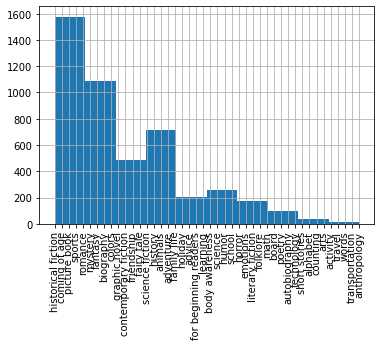

In [14]:
train_data["Genre"].hist(xrot=90);

In [ ]:
book_genre_cat = train_data[["Genre"]]
book_genre_encoder = OneHotEncoder(handle_unknown='ignore')
book_genre_cat_1hot = book_genre_encoder.fit_transform(book_genre_cat)

train_book_genre_df = pd.DataFrame(book_genre_cat_1hot.todense(), 
                             index=train_data.index,
                             columns=book_genre_encoder.get_feature_names())

test_book_genre_df = pd.DataFrame(data = book_genre_encoder.transform(test_data[["Genre"]]).todense(), 
                                  index=test_data.index,
                                  columns=book_genre_encoder.get_feature_names())

## MinMaxScale Publication Date

In [ ]:
book_pub_year = train_data[["Publication date"]]
min_max_scaler = MinMaxScaler().fit(book_pub_year)
bp_year_MM = min_max_scaler.transform(book_pub_year)

train_bp_year_df = pd.DataFrame(data=bp_year_MM,
                          index=train_data.index, 
                          columns=["book_pub_year"])

test_bp_year_df = pd.DataFrame(data=min_max_scaler.transform(test_data[["Publication date"]]),
                              index=test_data.index,
                              columns=["book_pub_year"])

## Create BOW

In [ ]:
def generate_bow(x):
    """Create a bag of words and return the vecotorizer along with data frames"""
    #instantiate CountVectorizer()
    cv=CountVectorizer(min_df=2)
    # this step generates word counts for the words in your docs
    word_count_vector=cv.fit_transform(train_data[str(x)])
    
    train = pd.DataFrame(word_count_vector.todense(), 
                      index=train_data.index, 
                      columns=cv.get_feature_names())
    
    test = pd.DataFrame(cv.transform(test_data[str(x)]).todense(), 
                       index=test_data.index,
                       columns=cv.get_feature_names())

    return train, test

In [ ]:
train_text_df, test_text_df = generate_bow("text")

## Create Create Train and Test Data Frames

In [ ]:
train_x = pd.concat(objs=[train_text_df, train_bp_year_df, train_book_genre_df,
                         train_book_type_df],
                    axis=1)

train_y = train_data['csm_rating']

test_x = pd.concat(objs=[test_text_df, test_bp_year_df, test_book_genre_df,
                        test_book_type_df],
                    axis=1)

test_y = test_data['csm_rating']

In [21]:
"""
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 1),
    "learning_rate": uniform(0.003, 1), # default 0.1 
    "max_depth": randint(1, 100), # default 3
    "n_estimators": randint(5, 500), # default 100
    "subsample": uniform(0.7, 0.3)
}
"""

'\nparams = {\n    "colsample_bytree": uniform(0.7, 0.3),\n    "gamma": uniform(0, 1),\n    "learning_rate": uniform(0.003, 1), # default 0.1 \n    "max_depth": randint(1, 100), # default 3\n    "n_estimators": randint(5, 500), # default 100\n    "subsample": uniform(0.7, 0.3)\n}\n'

In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint

params = {
    "learning_rate": uniform(0.003, 1),# default 0.1 
    "n_estimators": randint(5, 500)}
    #"max_depth": randint(1, 100)} # default 100


xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', 
                             n_jobs=-1,
                             booster = "gblinear")

search = RandomizedSearchCV(xgb_model, 
                            param_distributions=params, 
                            random_state=42, 
                            n_iter=10, 
                            cv=3, 
                            verbose=3, 
                            return_train_score=True)

search.fit(train_x, train_y)

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.3775401188473625, n_estimators=353 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.3775401188473625, n_estimators=353, score=(train=0.779, test=0.738), total= 2.3min
[CV] learning_rate=0.3775401188473625, n_estimators=353 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV]  learning_rate=0.3775401188473625, n_estimators=353, score=(train=0.779, test=0.738), total= 2.2min
[CV] learning_rate=0.3775401188473625, n_estimators=353 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min remaining:    0.0s


[CV]  learning_rate=0.3775401188473625, n_estimators=353, score=(train=0.778, test=0.736), total= 2.2min
[CV] learning_rate=0.1864347898661638, n_estimators=76 ...............
[CV]  learning_rate=0.1864347898661638, n_estimators=76, score=(train=0.769, test=0.724), total=  32.4s
[CV] learning_rate=0.1864347898661638, n_estimators=76 ...............
[CV]  learning_rate=0.1864347898661638, n_estimators=76, score=(train=0.769, test=0.725), total=  32.2s
[CV] learning_rate=0.1864347898661638, n_estimators=76 ...............
[CV]  learning_rate=0.1864347898661638, n_estimators=76, score=(train=0.767, test=0.725), total=  33.2s
[CV] learning_rate=0.6016584841970366, n_estimators=107 ..............
[CV]  learning_rate=0.6016584841970366, n_estimators=107, score=(train=0.779, test=0.738), total=  43.2s
[CV] learning_rate=0.6016584841970366, n_estimators=107 ..............
[CV]  learning_rate=0.6016584841970366, n_estimators=107, score=(train=0.779, test=0.738), total=  43.1s
[CV] learning_rate

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 47.9min finished


Model with rank: 1
Mean validation score: 0.737 (std: 0.001)
Parameters: {'learning_rate': 0.6016584841970366, 'n_estimators': 107}



Parameters: {'learning_rate': 0.6016584841970366, 'n_estimators': 107}

In [ ]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',
                          learning_rate=0.6016584841970366,
                          n_estimators=107, 
                          booster = "gblinear")

In [27]:
#Fit the model with the training data
xg_reg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.6016584841970366,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=107, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [ ]:
#Predict the taget on the train data set
predict_train = xg_reg.predict(train_x)
predict_test = xg_reg.predict(test_x)

In [29]:
mean_absolute_error(train_y, predict_train)

1.5073792377385926

In [30]:
mean_absolute_error(test_y, predict_test)

1.6206345400449746

### Transform and Predict on the Test DF

In [ ]:
#Predict the target on the test dataset
predict_test = xg_reg.predict(test_x)

In [32]:
mean_absolute_error(predict_test, test_y)

1.6206345400449746

In [ ]:
test_errors = abs(predict_test - test_y)

In [ ]:
predictions  = pd.Series(predict_test, index=test_data.index, name="predictions")

In [ ]:
test_errors.name = "difference"

In [ ]:
test_results = pd.concat([test_data, test_errors, predictions], axis=1)

In [37]:
test_results.head()

,title,description,plot,csm_review,need_to_know,csm_rating,Genre,Book type,Publication date,text,difference,predictions
1291,"uglies: uglies quartet, book 1",thoughtful sci-fi price beauty.,"tally grown postapocalyptic world where, age 1...",author scott westerfeld manages delicate balan...,parents need know scott westerfeld's uglies se...,11,science fiction,fiction,2006,"uglies: uglies quartet, book 1 tally grown pos...",1.474905,9.525095
832,courage cat campbell,"appealing tale would-be witch laughs, insights.","ever since baby, cat campbell desperately hope...",kids determined pursue dream getting lot disco...,parents need know courage cat campbell appeali...,8,coming of age,fiction,2015,"courage cat campbell ever since baby, cat camp...",0.275402,8.275402
685,"indigo spell: bloodlines, book 3","third bloodlines adventure takes romantic, mag...","end golden lily, alchemist prodigy sydney sage...",readers patiently waiting sydney adrian relati...,parents need know indigo spell third installme...,13,fantasy,fiction,2013,"indigo spell: bloodlines, book 3 end golden li...",0.526063,12.473937
5101,love & gelato,teen grapples grief first love charming romance.,"17-year-old lina loses mom cancer, honors mom'...","light, fun, fast-paced romance charmer. still ...",parents need know love & gelato combination ro...,12,romance,fiction,2016,love & gelato 17-year-old lina loses mom cance...,2.132259,14.132259
2617,water horse,another sweet animal tale babe author.,kirstie finds appears unusually large fish egg...,"dick king-smith's specialty gentle, fairly eas...",parents need know aside water horse eating swa...,7,fantasy,fiction,1998,water horse kirstie finds appears unusually la...,0.181522,7.181522


In [38]:
test_results.sort_values(by="difference").head(10)

,title,description,plot,csm_review,need_to_know,csm_rating,Genre,Book type,Publication date,text,difference,predictions
2544,"witherwood reform school, book 1","creepy school holds kids captive dark, funny f...","ever since mother died, 12-year-old tobias 11-...",kids hard time seeing funny side emotionally h...,parents need know there's plenty cartoonish cr...,9,fantasy,fiction,2015,"witherwood reform school, book 1 ever since mo...",0.000337,9.000337
17,"burning kingdoms: internment chronicles, book 2","second, stronger installment focuses characters.","morgan stockhour, remaining family, fellow reb...",lauren destefano's eloquent prose perfectly ca...,parents need know burning kingdoms second laur...,11,contemporary fiction,fiction,2015,"burning kingdoms: internment chronicles, book ...",0.003533,11.003533
5069,impostors,action cool tech uglies quartet spin-off.,"impostors, one town knows rafi, first daughter...",page-turner set world uglies quartet high acti...,parents need know impostors first book spin-of...,12,science fiction,fiction,2018,"impostors impostors, one town knows rafi, firs...",0.004679,11.995321
1482,american girls,riveting tale runaway discovering hollywood un...,anna's home life atlanta going great. parents ...,"smart, funny, intriguing look teen-to-adult tr...",parents need know american girls coming-of-age...,13,coming of age,fiction,2016,american girls anna's home life atlanta going ...,0.005243,13.005243
4387,foul fair,"dark, violent revenge tale teen update ""macbeth.""","foul fair, elle khanjara goes big night friend...",over-the-top revenge tale starts intense juicy...,parents need know foul fair modern take willia...,14,contemporary fiction,fiction,2020,"foul fair foul fair, elle khanjara goes big ni...",0.008232,13.991768
1554,school spirits (a hex hall novel),teen ghost hunter blends high school fun spin-...,school spirits 15-year-old ghost hunter named ...,school spirit unfortunately saves action end; ...,"parents need know school spirits, spin-off rac...",12,fantasy,fiction,2013,school spirits (a hex hall novel) school spiri...,0.011222,11.988778
1446,"click, clack, surprise!",fun bath-time book shows lots ways get clean.,"click, clack, surprise!, little duck's birthda...",cute installment shows different animals get c...,"parents need know doreen cronin's click, clack...",4,picture book,fiction,2016,"click, clack, surprise! click, clack, surprise...",0.016390,3.983610
757,"leven thumps gateway foo (leven thumps, book 1)",occasionally fun long poorly written.,"orphaned, mistreated leven contacted tiny crea...","book, reads like written gifted 12-year-old, p...",parents need know mild fantasy violence here: ...,9,fantasy,fiction,2006,"leven thumps gateway foo (leven thumps, book 1...",0.017899,9.017899
2010,wainscott weasel,charming tale weasel's adventure protect love.,"bagley brown, jr. weasel mostly keeps himself....",tor seidler brings wainscott woods life vivid ...,parents need know wainscott weasel delightful ...,7,adventure,fiction,1993,"wainscott weasel bagley brown, jr. weasel most...",0.018264,7.018264
2053,wish list,"wicked key word here, senses.","meg finn's short life mess. mother dead, stepf...",eoin colfer knows grab readers: first 10 pages...,parents need know colfer offers view afterlife...,10,fantasy,fiction,2003,wish list meg finn's short life mess. mother d...,0.019487,9.980513


In [39]:
test_results.sort_values(by="difference").tail(10)

,title,description,plot,csm_review,need_to_know,csm_rating,Genre,Book type,Publication date,text,difference,predictions
992,"no, david!",lovable david's antics relentless.,comes trouble! david shannon's disorderly litt...,"david shannon caldecott honor book, reasons ob...",parents need know simple story caters desperad...,2,picture book,fiction,1998,"no, david! comes trouble! david shannon's diso...",5.072558,7.072558
1435,ladybug girl dress-up dilemma,ladybug girl picks halloween costume charming ...,"halloween! lulu, advice older brother, must la...","ladybug girl series fires cylinders, ladybug g...",parents need know ladybug girl dress-up dilemm...,3,picture book,fiction,2014,"ladybug girl dress-up dilemma halloween! lulu,...",5.081315,8.081315
2466,art losing,"authentic, realistic story addiction, survival...","art losing, 17-year-old harley langston's life...","absorbing, riveting story addiction, family, l...",parents need know lizzy mason's art losing pow...,16,contemporary fiction,fiction,2019,"art losing art losing, 17-year-old harley lang...",5.230301,10.769699
603,alligators around,alligators take readers abcs.,f fooling. g giggles. primer family alligators...,"words fun effective illustrations charming, ma...",parents need know words chosen memorability al...,2,alphabet,non-fiction,1969,alligators around f fooling. g giggles. primer...,5.258621,7.258621
705,"silence: queen dead, book 1",paranormal adventure bogs details.,"silence, strange encounter cemetery leaves hig...","silence interesting, suspenseful premise engag...",parents need know silence (the first book quee...,16,fantasy,fiction,2012,"silence: queen dead, book 1 silence, strange e...",5.296560,10.703440
2516,beatrix potter: complete tales,"beatrix potter one book, pre-k k.","tales peter rabbit, jemima puddle-duck, mr. to...",beatrix potter's art reproduced fine detail br...,parents need know old-fashioned values here. c...,2,animals,fiction,1969,beatrix potter: complete tales tales peter rab...,5.326140,7.326140
2955,high moon,girl seeks family secrets hopeful jim crow-era...,"1943, 12-year-old ella friends myrna nd henry ...",heartfelt tale childhood jim crow south brings...,parents need know high moon hopeful historical...,8,coming of age,fiction,2019,"high moon 1943, 12-year-old ella friends myrna...",5.367842,13.367842
980,fade,dark tale good boy misled temptation.,supernatural morality tale thirteen-year-old p...,"fade offers subject intrigues teenagers, read ...",parents need know story focuses otherwise good...,15,fantasy,fiction,1988,fade supernatural morality tale thirteen-year-...,5.395847,9.604153
2988,"escape asylum: asylum, book 0.5",repetitive prequel best longtime fans.,escape asylum opens ricky desmond's admittance...,sometimes prequel popular series add something...,parents need know escape asylum historical pre...,16,horror,fiction,2016,"escape asylum: asylum, book 0.5 escape asylum ...",6.089161,9.910839
5202,pole (and you!),"clever, satirical picture book really kids.","pole know type pole be, tries find \""true pole...",satire-savvy fans wordplay stephen colbert's h...,parents need know comedian stephen colbert's p...,12,picture book,fiction,2012,"pole (and you!) pole know type pole be, tries ...",6.170554,5.829446
